In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']
missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']


    
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)  

        
y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
num_trials = 5
training_test = []

#initilize folds
kf = KFold(n_splits=num_trials,shuffle=True)
folds_indexes = kf.split(y)

for fold_index in folds_indexes:
    X_train, y_train = sm.add_constant(X).iloc[fold_index[0]], y.iloc[fold_index[0]]
    X_test, y_test = sm.add_constant(X).iloc[fold_index[1]], y.iloc[fold_index[1]]
    training_test.append( (X_train, X_test, y_train, y_test) )

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_test > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

mse normalized trial  0 : 0.3795411458886019 9880892.679789886 15925137.685303876
mse normalized trial  1 : -0.289301459972902 19439196.999829106 15077309.382894572
mse normalized trial  2 : 0.2072388272321295 49409845.62323209 62326268.390164785
mse normalized trial  3 : 0.23263951742776234 22249409.372534003 28994729.175983455
mse normalized trial  4 : 0.2142870221246811 36597310.38892123 46578472.5713525


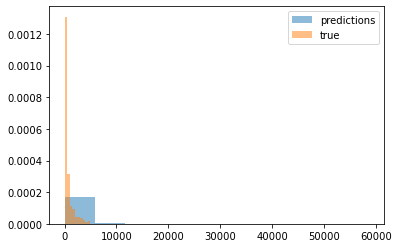

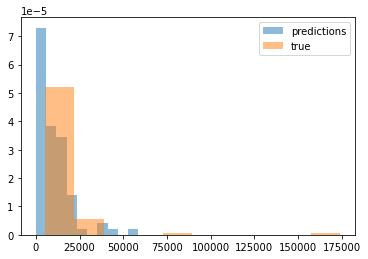

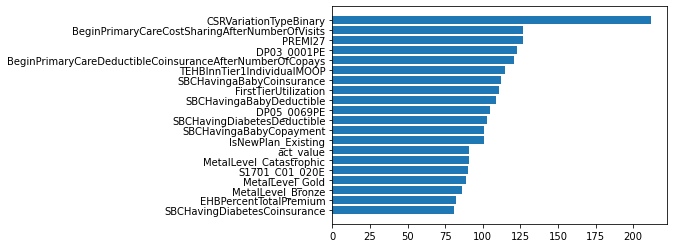

mse 27515331.012861263 r2 0.1854179063680682
mse med 22249409.372534003 r2 med 0.23263951742776234


In [5]:
params = [(5,.1,.5,.5)]
#(2,.2,.5,.9)
#(2,.5,.9,.9),(5,.5, 0.5, .9),

for param in params:
    mses = []
    r2s = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[i]
        # not super deep, but uses most of the data at one
        model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                             eta=param[1], subsample=param[2], colsample_bytree=param[3])
        model.fit(X_train, y_train)

        y_pred = get_predictions(model,X_test)
        mse = float( ((y_test - y_pred)**2).mean() )
        r2 = float(  1- mse/y_test.var() )
        print('mse normalized trial ', i,':', r2, mse, float(y_test.var()) )
        mses.append(mse)
        r2s.append(r2)

        #plot the difference between true and predicted
        if i == num_trials -1:
            split = 5000
            plot_prediction(split,y_pred,y_test)
            plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/y.var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )

mse normalized trial  0 : 0.2954274318008091 11220415.15786027 15925137.685303876
mse normalized trial  1 : 0.2897333955992666 10708909.338887844 15077309.382894572
mse normalized trial  2 : 0.2578962923967133 46252554.85341882 62326268.390164785
mse normalized trial  3 : 0.36184817958035254 18503039.206228506 28994729.175983455
mse normalized trial  4 : 0.1379368586908426 40153584.38224256 46578472.5713525


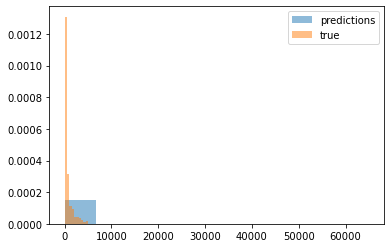

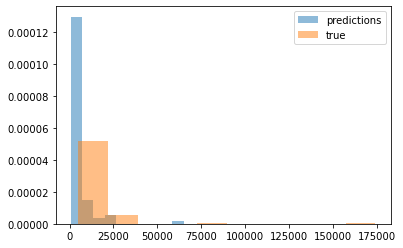

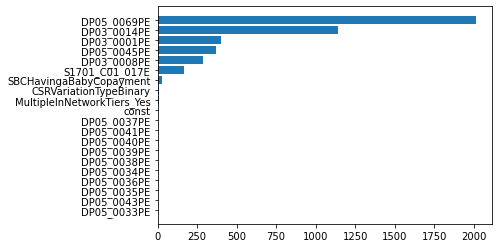

mse trial 4 :                pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
IL     24811.329972         53458.500000      5.864778  49366.659929
AZ     21704.609801          3951.000000           NaN           NaN
FL     18248.137269         30003.545455  23626.524199  48816.378769
NJ      9665.821111          2392.000000     35.041843   2070.408655
TX      9387.811704          9365.375000   4178.830081   7586.228876
OR      7456.459719           336.000000           NaN           NaN
GA      6424.436060         16372.000000   1308.183868  12443.172130
UT      4465.628485         18699.750000   4445.861579  10933.791668
TN      4215.267885         19405.666667   1359.636535   8677.915207
OK      4047.983252         25732.000000           NaN           NaN
PA      4015.856470         18818.000000    509.229355   9499.252655
NC      4013.852323         14860.166667   2050.097835   4883.282683
VA      2943.661339 

In [6]:
# Vary alpha values
a = [250]

for i in a: 
    mses = []
    r2s = []
    for j in range(num_trials):
        X_train, X_test, y_train, y_test = training_test[j]
        
        lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
        y_pred = get_predictions(lasso,X_test)

        mse = float(((y_test - y_pred)**2).mean())
        r2 = float( 1 - mse/y_test.var() )
        print('mse normalized trial ', j,':', r2, mse, float(y_test.var()) )
        mses.append(mse)
        r2s.append(r2)
        

        if j == num_trials -1:
            #plot the difference between true and predicted
            split = 5000
            plot_prediction(split,y_pred,y_test)

            #also plot important feature
            param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
            param_df['features'] = param_df.index
            plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
            plt.show()
            print('mse trial', j, ':',report_error(y_test,y_pred))

    print('alpha_value:', i)
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', np.array(mses).mean() ,'r2', 1 - float(np.array(mses).mean()/y.var()) )
    print( 'mse med', np.median(mses) ,'r2 med',r2s.reshape(num_trials,1)[mses == np.median(mses)][0,0] )
    print('==========================================')
    print('==========================================')

In [7]:
#some training sets total number of consumers?
#some times DP03_CSR?